In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
directory = './rockpaperscissors'
print(os.listdir(directory))

['rps-cv-images', 'paper', 'README_rpc-cv-images.txt', 'scissors', 'rock']


In [3]:
labels = ['paper','scissors','rock']
nb = len(labels)

In [4]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

# **Dividing the Images and Labels**

In [5]:
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(f'\rCompleted: {label}',end='')
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [6]:
X, y = input_target_split(directory,labels)

Completed: rock

# **Visualizing the Images**

In [7]:
import matplotlib.pyplot as plt

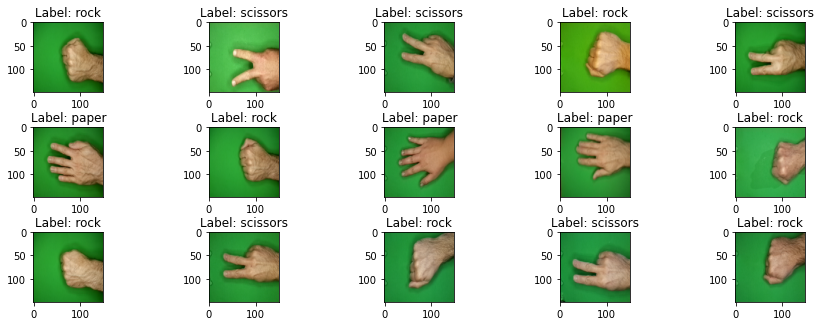

In [8]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title(f'Label: {labels[y[i]]}')

In [9]:
np.unique(y,return_counts=True)

(array([0, 1, 2]), array([712, 750, 726]))

# **Splitting the images and labels into training and test set**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)
print(np.unique(y_train,return_counts=True),np.unique(y_test,return_counts=True))

(array([0, 1, 2]), array([568, 579, 559])) (array([0, 1, 2]), array([144, 171, 167]))


# **Applying Data Augmentation Techniques**

In [11]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

In [12]:
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

# **Defining the CNN Model**

In [13]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

# **Compiling the model with its optimizer, loss function and metric**

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

# **Defining the callbacks for the model such as EarlyStopping and Best Model Checkpoint**

In [16]:
filepath= "model_cnn_final.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.2, 
#                                             min_lr=0.00001)

callbacks_list = [
        checkpoint,
        early_stopping,
#         learning_rate_reduction
    ]


In [17]:
hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),
                                        validation_data=testgen.flow(X_test,y_test,batch_size=32),
                                        epochs=50,
                                        callbacks=callbacks_list)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 1.6050 - accuracy: 0.4109
Epoch 00001: val_accuracy improved from -inf to 0.56432, saving model to model_cnn_final.h5
54/54 [==============================] - 9s 172ms/step - loss: 1.6050 - accuracy: 0.4109 - val_loss: 0.8823 - val_accuracy: 0.5643
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.5873
Epoch 00002: val_accuracy improved from 0.56432 to 0.85477, saving model to model_cnn_final.h5
54/54 [==============================] - 9s 171ms/step - loss: 0.9038 - accuracy: 0.5873 - val_loss: 0.6013 - val_accuracy: 0.8548
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.7186
Epoch 00003: val_accuracy improved from 0.85477 to 0.89419, saving model to model_cnn_final.h5
54/54 [==============================] - 9s 171ms/step - loss: 0.6697 - accuracy: 0.7186 - val_loss: 0.3991 - val_accuracy: 0.8942
Epoch 4/50
54/54 [=========================

In [18]:
model_saved = tf.keras.models.load_model('model_cnn_final.h5')

In [19]:
y_pred = model_saved.predict(X_test)
pred = np.argmax(y_pred,axis=1)
print(pred)

[2 0 2 0 2 0 2 1 2 0 0 2 1 2 1 2 1 1 2 2 0 2 0 0 2 1 2 2 0 1 2 2 2 2 2 1 2
 2 0 1 0 1 0 1 1 2 0 1 1 1 1 0 1 2 2 1 2 1 2 0 0 1 0 2 2 0 2 1 1 0 0 0 2 2
 1 0 0 2 2 1 1 1 2 0 2 0 0 0 0 1 1 1 1 1 2 2 1 0 2 0 0 0 1 1 0 2 1 0 1 2 0
 1 2 1 1 2 0 2 2 2 1 1 2 1 0 1 2 1 2 1 0 1 0 1 0 2 0 2 1 2 1 0 0 0 2 0 0 1
 0 2 1 0 0 2 1 2 0 1 1 2 0 2 0 2 2 1 2 0 1 2 0 2 0 2 2 2 1 0 1 0 1 2 1 1 1
 2 0 0 1 2 0 0 2 1 2 2 0 2 1 1 1 0 2 2 1 1 1 1 0 0 2 2 1 1 0 0 0 0 2 0 1 2
 1 0 1 1 0 2 1 2 0 1 2 1 0 2 1 1 1 1 0 1 1 1 1 2 2 0 2 2 1 2 0 1 1 2 2 2 0
 2 1 2 2 2 2 2 2 1 0 2 2 1 0 0 0 1 1 2 0 2 2 1 0 1 0 2 2 2 2 1 1 0 1 2 1 0
 0 1 1 2 1 1 0 2 2 0 1 1 2 0 1 0 0 2 1 1 2 1 2 1 0 0 1 1 2 1 0 0 1 1 0 0 2
 2 1 0 0 1 0 2 0 0 2 0 1 2 1 1 0 1 2 1 1 2 0 2 1 1 2 2 0 1 2 2 0 1 0 1 2 1
 2 2 1 0 1 0 2 1 2 2 2 1 1 0 2 1 2 2 2 1 1 0 1 0 2 1 0 1 0 2 0 2 1 1 2 0 0
 1 0 1 0 2 0 0 2 0 1 2 1 1 1 0 1 2 1 0 1 2 1 0 2 2 2 0 1 2 2 0 2 1 2 1 1 1
 2 2 2 1 0 1 2 0 0 0 1 2 1 2 2 2 2 1 2 0 1 1 1 2 1 1 2 1 2 1 2 0 0 2 0 0 0
 2]


In [20]:
ground = np.argmax(y_test,axis=1)

# **Classification Report of the model**

In [21]:
from sklearn.metrics import classification_report

print(classification_report(ground,pred,target_names = labels))

              precision    recall  f1-score   support

       paper       1.00      0.97      0.99       144
    scissors       0.99      0.99      0.99       171
        rock       0.98      1.00      0.99       167

    accuracy                           0.99       482
   macro avg       0.99      0.99      0.99       482
weighted avg       0.99      0.99      0.99       482

